In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [105]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src/transformers')
import os
device_mappings = {0: 1, 1: 5, 2: 6, 3: 7, 4: 2, 5: 3, 6: 0, 7: 4}
os.environ["CUDA_VISIBLE_DEVICES"] = str(device_mappings[7])

import random
import string
from collections import defaultdict, OrderedDict
from itertools import product, chain
import numpy as np
from pattern.en import comparative

import matplotlib.pyplot as plt
import seaborn as sns

from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from enum import Enum
from typing import List, Optional, Union

from child_frames import frames
from utils import *

import logging
import os
import sys

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
from transformers import PreTrainedModel, RobertaForMaskedLM, RobertaTokenizer
from transformers.modeling_roberta import RobertaForProbing, RobertaDoubleHeadsModel, \
    RobertaDoubleHeadsModel2, RobertaDoubleHeadsModel3  # XD

logging.basicConfig(level=logging.ERROR)

In [5]:
A_template = "{rel_prefix} {dt} {ent0} {rel} {dt} {ent1} {rel_suffix}"
B_template = "{pred_prefix} {dt} {ent} {pred}"
entailment_templates = ["{A} ? {conj} , {B} .", "{A} , so {B} ? {conj} ."]

markers = {'lexical': '*', 'entity': '#'}

def extract_rel_id(s): return int(s[s.index(':') + 1])
def extract_rel(s): return [t.split(':')[0] for t in s.split() if ':' in t][0]
def strip_rel_id(s, lexical_rel=''):
    rel_id_span = s[s.index(':'): s.index(':') + 2]
    if lexical_rel != '': lexical_rel = ' ( ' + lexical_rel + ' )'
    return s.replace(rel_id_span, lexical_rel)
        
relation_labels = {'entity': ['former', 'latter'], 'lexical': ['same', 'opposite', 'unrelated']}

def make_sentences(entities=['_X', '_Z'], entity_set=string.ascii_uppercase, determiner="",
                   relation_group=[["confident",], ["uncertain",]], rand_relation_group=[["short"], ["tall", "high"]],
                   relation_prefix="", relation_suffix="", predicate_prefix="",
                   n_entity_trials=3, has_negA=True, has_negB=True, has_neutral=False, mask_types={'sent_rel'}, 
                   lexical_relations=None, entity_relations=None, tag_lexical_rel=False, tag_entity_rel=False):
#     if tag_lexical_rel: mask_types.add('lexical_rel')
#     if tag_entity_rel: mask_types.add('entity_rel')
    def get_comparative(word):
        compar = comparative(word)
        if tag_lexical_rel:
            marker = markers['lexical']
            compar = compar.replace('more ', 'more %s ' % marker) if compar.startswith('more ') else marker + ' ' + compar
        return compar
  
    def form_As(relations):
        return [A_template.format(dt=determiner, ent0=ent0, ent1=ent1, rel=rel, 
                                  rel_prefix=relation_prefix, rel_suffix=relation_suffix)
              for ent0, ent1, rel in [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
    As = []
    for rel0 in relation_group[0]:
        for rel1 in relation_group[1]:
            relations = ["is %s:%d than" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
            As += form_As(relations)
    As = list(set(As))
    negAs = join_lists([negate_sent(A)[:1] for A in As]) if has_negA else []

    def form_Bs(predicates): 
        f = mask if 'entity' in mask_types else (lambda x: x)
        return [B_template.format(dt=determiner, ent=f(ent), pred=pred, pred_prefix=predicate_prefix)
              for ent, pred in zip(entities, predicates)]

    Bs, negBs = {'orig': [], 'rand': []}, {}
    for k, group in zip(['orig', 'rand'], [relation_group, rand_relation_group]):
        for rel0 in group[0]:
            for rel1 in group[1]:
                predicates = ["is %s:%d" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
                Bs[k] += form_Bs(predicates)
    for k in Bs:
        Bs[k] = list(set(Bs[k]))
        if has_negB:
            negBs[k] = join_lists([negate_sent(B)[:1] for B in Bs[k]])
            Bs[k], negBs[k] = Bs[k] + [swap_entities(negB) for negB in negBs[k]], negBs[k] + [swap_entities(B) for B in Bs[k]]
        else:
            negBs[k] = [swap_entities(B) for B in Bs[k]]
      
    comparatives = [comparative(r).replace('more ', '') for r in join_lists(relation_group) + join_lists(rand_relation_group)]
    def form_sentences(sentence_template, As, Bs, conj):
        def compare_and_tag_comparative(A, B):
            if 'Maybe' in conj:
                lexical_rel = 'unrelated'
            else:
                lexical_rel = 'same' if extract_rel_id(A) == extract_rel_id(B) else 'opposite'
            if lexical_relations and lexical_rel not in lexical_relations:
                return None, None
            if 'lexical_rel' in mask_types: lexical_rel = mask(lexical_rel)
            return strip_rel_id(A), strip_rel_id(B, lexical_rel)
#             triple = '%s %s %s' % (extract_rel(A), lexical_rel, extract_rel(B))
#             return strip_rel_id(A), strip_rel_id(B), triple
        def tag_entity(token, recurred_entity, entity_rel=None):
            if token != recurred_entity: return token
            return markers['entity'] + ' ' + token
#             if token not in entities: return token
#             entity_rel = 'paired' if token == recurred_entity else 'single'
#             if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
#             return token + ' ( %s )' % entity_rel
        def compare_and_tag_entity(A, B):
            recurred_entity = [e for e in entities if e in B.split()][0]
            A = ' '.join([tag_entity(token, recurred_entity) for token in A.split()])
            B = ' '.join([tag_entity(token, recurred_entity) for token in B.split()])
            entity_rel = 'former' if A.split().index(recurred_entity) in [0, 1] else 'latter'
            if entity_relations and entity_rel not in entity_relations: return None, None
            if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
            return A, B.replace(recurred_entity, recurred_entity + ' ( ' + entity_rel + ' )')
#             triple = '%s %s %s' % (recurred_entity, entity_rel, recurred_entity)
#             return A, B, triple
        
        if 'sent_rel' in mask_types: conj = mask(conj)
        sentences = []
        cores = []
        for A, B in product(As, Bs):
            A, B = compare_and_tag_comparative(A, B) \
                if tag_lexical_rel else (strip_rel_id(A), strip_rel_id(B))
            if A is None: continue
#             entity_triple = None
            if tag_entity_rel: A, B = compare_and_tag_entity(A, B)
            if A is None: continue
            sent = sentence_template.format(A=A, B=B, conj=conj)
#             triples = ' , '.join([t for t in [entity_triple, lexical_triple] if t is not None])
#             if triples: sent = sent + ' Hint : ' + triples
            sent = " " + " ".join(sent.split())
            if True: #for sent_type in sentence_types:
                sentences.append(sent)
                for rel_type in {'entity', 'lexical'}:
                    if not locals()['tag_' + rel_type + '_rel']: continue
#                 if 'core' in sent_type:
#                     rel_type = sent_type.split('_')[1]
#                     assert rel_type in {'entity', 'lexical'}
                    the_other_rel_type = ({'entity', 'lexical'} - {rel_type}).pop()
                    excluded_tokens = comparatives if rel_type == 'entity' else entities
                    # wrong, because it will change the default value of entities!
                    # excluded_tokens += ['is', 'not', 'less', 'more', 'than', 'so'] + list(markers.values()) 
                    excluded_tokens = excluded_tokens + ['is', 'not', 'less', 'more', 'than', 'so'] + list(markers.values())
                    core = sent.split('?')[0]
                    for span in ['( [ %s ] )' % r for r in relation_labels[the_other_rel_type]]:
                        core = core.replace(span, '')
                    core = [token for token in core.split() if token not in excluded_tokens]
                    core = " " + " ".join(core)
                    core = core.replace('(', '?').replace(')', '.')
                    cores.append(core)
        return sentences, cores
    
    sentences = defaultdict(list)
    cores = defaultdict(list)
    for entailment_template in entailment_templates[-1:]:
        for A, B, conj in [(As, Bs['orig'], 'Right'), (negAs, negBs['orig'], 'Right'), 
                           (As, negBs['orig'], 'Wrong'), (negAs, Bs['orig'], 'Wrong'),
                           (As, Bs['rand'], 'Maybe'), (negAs, negBs['rand'], 'Maybe'), 
                           (As, negBs['rand'], 'Maybe'), (negAs, Bs['rand'], 'Maybe')]:
            ss, cs = form_sentences(entailment_template, A, B, conj)
            sentences[conj] += ss
            cores[conj] += cs
    assert len(sentences['Right']) == len(sentences['Wrong']), \
        '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    if has_neutral:
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    keys = sentences.keys() if has_neutral else ['Right', 'Wrong']
    sentences = join_lists(sentences[k] for k in keys)
    
    def substitute(templates, n_entity_trials):
        substituted_groups = []
        for template in templates:
            group = []
            for _ in range(n_entity_trials):
                e0, e1 = random.sample(entity_set, 2)
                group.append(template.replace(entities[0], e0).replace(entities[1], e1))
            substituted_groups.append(group)
        return substituted_groups
    
    substituted_sent_groups = substitute(sentences, n_entity_trials=n_entity_trials)
    cores = list(set(join_lists(cores[k] for k in keys)))
    cores = balance(cores, relation_labels)
    substituted_core_groups = substitute(cores, n_entity_trials=1)
    return sentences, cores, substituted_sent_groups, substituted_core_groups

make_sentences(has_negA=False, has_negB=False, has_neutral=False, tag_lexical_rel=True, tag_entity_rel=False,
               mask_types={'sent_rel'})[:2] # ,

([' _Z is more * uncertain than _X , so _Z is more * uncertain ( same ) ? [ Right ] .',
  ' _Z is more * uncertain than _X , so _X is more * confident ( opposite ) ? [ Right ] .',
  ' _X is more * confident than _Z , so _Z is more * uncertain ( opposite ) ? [ Right ] .',
  ' _X is more * confident than _Z , so _X is more * confident ( same ) ? [ Right ] .',
  ' _Z is more * uncertain than _X , so _X is more * uncertain ( same ) ? [ Wrong ] .',
  ' _Z is more * uncertain than _X , so _Z is more * confident ( opposite ) ? [ Wrong ] .',
  ' _X is more * confident than _Z , so _X is more * uncertain ( opposite ) ? [ Wrong ] .',
  ' _X is more * confident than _Z , so _Z is more * confident ( same ) ? [ Wrong ] .'],
 [' uncertain , uncertain ? same .',
  ' confident , confident ? same .',
  ' uncertain , confident ? opposite .',
  ' confident , uncertain ? opposite .'])

In [6]:
def make_transitive(entities=["_X", "_Y", "_Z"], entity_set=string.ascii_uppercase,
                    relation_group=[["confident", ], ["uncertain", ]], n_entity_trials=3,
                    has_negP=True, has_negQ=True, has_neutral=False, mask_types=['sent_rel']):
    def form_atoms(relations, entities, has_neg=True):
        atoms = [P_template.format(ent0=ent0, ent1=ent1, rel=rel) for ent0, ent1, rel in
                 [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
        if has_neg:
            neg_rels = [negate_sent(r)[0] for r in relations]
            atoms += [P_template.format(ent0=ent0, ent1=ent1, rel=rel) for ent0, ent1, rel in
                      [entities + reverse(neg_rels)[:1], reverse(entities) + neg_rels[:1]]]
        return atoms

    def form_sentences(transitive_template, Ps, Qs, conj):
        sentences = []
        if 'sent_rel' in mask_types: conj = mask(conj)
        for (p0, p1), Q in product(Ps, Qs):
            sent = transitive_template.format(p0=strip_rel_id(p0), p1=strip_rel_id(p1),
                                              Q=strip_rel_id(Q), conj=conj)
            sent = " " + " ".join(sent.split())
            sentences.append(sent)
        return sentences

    def form_all(P0_entities, P1_entities, Q_entities, neutral=False):
        P0, P1 = [], []
        for rel0 in relation_group[0]:
            for rel1 in relation_group[1]:
                relations = [" is %s:%d than" % (comparative(rel), i)
                             for i, rel in enumerate([rel0, rel1])]
                P0 += form_atoms(relations, P0_entities, has_neg=has_negP)
                P1 += form_atoms(relations, P1_entities, has_neg=has_negP)
        Ps = [(p0, p1) for p0, p1 in list(product(P0, P1)) + list(product(P1, P0))]

        Qs = form_atoms(relations, Q_entities, has_neg=has_negQ)
        negQs = [swap_entities(Q, *Q_entities) for Q in Qs]

        for P, Q, conj in [(Ps, Qs, 'Right'), (Ps, negQs, 'Wrong')]:
            if neutral: conj = 'Maybe'
            sentences[conj] += form_sentences(transitive_template, P, Q, conj)
        return sentences

    e0, e1, e2 = entities
    sentences = defaultdict(list)
    form_all(P0_entities=[e0, e1], P1_entities=[e1, e2], Q_entities=[e0, e2])
    assert len(sentences['Right']) == len(sentences['Wrong']), \
        '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    sample_ratio = len(relation_group[0]) * len(relation_group[1])
    if sample_ratio > 1:
        for key in sentences:
            sentences[key] = random.sample(sentences[key], len(sentences[key]) // sample_ratio)
#     print('nRight =', len(sentences['Right']))
    if has_neutral:
        form_all(P0_entities=[e0, e1], P1_entities=[e0, e2], Q_entities=[e1, e2], neutral=True)
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    keys = sentences.keys() if has_neutral else ['Right', 'Wrong']
    sentences = join_lists(sentences[k] for k in keys)

    substituted_sent_groups = []
    for sent in sentences:
        sent_group = []
        for _ in range(n_entity_trials):
            e0, e1, e2 = random.sample(entity_set, 3)
            sent_group.append(sent.replace(entities[0], e0)
                              .replace(entities[1], e1)
                              .replace(entities[2], e2))
        substituted_sent_groups.append(sent_group)
    return sentences, substituted_sent_groups

# make_transitive(has_negP=True, has_negQ=True, has_neutral=True, mask_types=['sent_rel'])[1]

In [7]:
tokenizer_class, shortcut = RobertaTokenizer, 'roberta-base'
tokenizer = tokenizer_class.from_pretrained(shortcut)

In [8]:
## rand_relation_group=_frames[(i + 1) % len(_frames)], 
random.seed(42)
random.shuffle(frames)
entity_set = list(string.ascii_uppercase)
random.shuffle(entity_set)
split_pct = [0.7, 0.3]

In [302]:
tag2id = {'same': 0, 'opposite': 1, 'unrelated': 2, 'former': 0, 'latter': 1, 'another': 5, 'single': 6, 'paired': 7}
tag2id = {'Ġ' + k: v for k, v in tag2id.items()}
id2tag = {v: k for k, v in tag2id.items()}

n_entity_trials = 3
kwargs = {'n_entity_trials': n_entity_trials, 'has_neutral': False, 'has_negA': False, 'has_negB': False, 
          'tag_lexical_rel': False, 'tag_entity_rel': True, 'mask_types': {'sent_rel',}}
train_lines, eval_lines = [[make_sentences(relation_group=rg, entity_set=_ent_set, **kwargs)[2] for i, rg in enumerate(_frames)]
                           for _frames, _ent_set in zip(split(frames, split_pct), split(entity_set, split_pct))]
random.sample(flatten(train_lines), 10)
# all_lines = [make_transitive(relation_group=rg, n_entity_trials=n_entity_trials,
#                              has_negP=True, has_negQ=True, has_neutral=True, mask_types=['sent_rel'])[1]
#              for i, rg in enumerate(frames)]
# all_lines = join_lists(all_lines)
# all_lines = join_lists(all_lines)
tokenizer.tag2id, tokenizer.id2tag = tag2id, id2tag
# for k in CHILDDataset.all_lines: CHILDDataset.all_lines[k] = None
kwargs = {'has_tags': True, 'max_noise_len': 0, 'n_replicas': 1}
train_dataset = CHILDDataset(train_lines, tokenizer, mode='train', **kwargs)
eval_dataset = CHILDDataset(eval_lines, tokenizer, mode='dev', **kwargs)
print('nTrain = %d, nValid = %d' % (len(train_dataset), len(eval_dataset)))

[' # Y is heavier than J , so # Y ( former ) is heavier ? [ Right ] .',
 ' O is fewer than # X , so # X ( latter ) is fewer ? [ Wrong ] .',
 ' T is earlier than # J , so # J ( latter ) is later ? [ Right ] .',
 ' # B is more inactive than E , so # B ( former ) is more inactive ? [ Right ] .',
 ' # F is more legal than A , so # F ( former ) is more illegal ? [ Wrong ] .',
 ' L is more unpopular than # R , so # R ( latter ) is more unpopular ? [ Wrong ] .',
 ' A is more expensive than # C , so # C ( latter ) is dearer ? [ Wrong ] .',
 ' X is more favorable than # I , so # I ( latter ) is more favorable ? [ Wrong ] .',
 ' # J is more comfortable than X , so # J ( former ) is more uncomfortable ? [ Wrong ] .',
 ' # F is more ignorant than Q , so # F ( former ) is more ignorant ? [ Right ] .']

nTrain = 2562, nValid = 1122


In [360]:
# model_class, model = RobertaForMaskedLM, None
model_class, model = RobertaForProbing, None
model = model_class.from_pretrained('roberta-base', state_dict=state_dict)
steps = max(int(round(100 * n_entity_trials / 3)), int(len(train_dataset) / 32 / 4))
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=32, per_device_eval_batch_size=64,
    learning_rate=2e-4, num_train_epochs=10,
    logging_steps=steps, eval_steps=steps, save_steps=0,
    no_cuda=False, evaluate_during_training=True,
)
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset)
trainer.tokenizer = tokenizer
model.tokenizer = tokenizer
trainer.train()

{'loss': 0.606487, 'learning_rate': 0.00017530864197530866, 'epoch': 1.235, 'step': 100}



{'eval_loss': 0.520589, 'eval_acc_0': 0.893, 'eval_acc_tc0': 0.5, 'eval_acc_tc1': 0.5, 'eval_acc_tc2': 0.5, 'eval_acc_tc3': 0.504, 'eval_acc_tc4': 0.5, 'eval_acc_tc5': 0.504, 'eval_acc_tc6': 0.5, 'eval_acc_tc7': 0.53, 'eval_acc_tc8': 0.591, 'eval_acc_tc9': 0.501, 'eval_acc_tc10': 0.5, 'eval_acc_tc11': 0.506, 'eval_acc_tc12': 0.5, 'eval_acc_tc13': 0.541, 'eval_acc_tc14': 0.515, 'eval_acc_tc15': 0.58, 'eval_acc_tc16': 0.502, 'eval_acc_tc17': 0.5, 'eval_acc_tc18': 0.511, 'eval_acc_tc19': 0.724, 'eval_acc_tc20': 0.619, 'eval_acc_tc21': 0.832, 'eval_acc_tc22': 0.5, 'eval_acc_tc23': 0.501, 'eval_acc_tc24': 0.5, 'eval_acc_tc25': 0.911, 'eval_acc_tc26': 0.893, 'eval_acc_tc27': 0.896, 'eval_acc_tc28': 0.5, 'eval_acc_tc29': 0.503, 'eval_acc_tc30': 0.5, 'eval_acc_tc31': 0.99, 'eval_acc_tc32': 0.99, 'eval_acc_tc33': 0.975, 'eval_acc_tc34': 0.623, 'eval_acc_tc35': 0.517, 'eval_acc_tc36': 0.5, 'eval_acc_tc37': 0.988, 'eval_acc_tc38': 0.925, 'eval_acc_tc39': 0.951, 'eval_acc_tc40': 0.869, 'eval_acc_

{'loss': 0.521661, 'learning_rate': 0.0001506172839506173, 'epoch': 2.469, 'step': 200}



{'eval_loss': 0.467407, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.497, 'eval_acc_tc1': 0.497, 'eval_acc_tc2': 0.499, 'eval_acc_tc3': 0.497, 'eval_acc_tc4': 0.497, 'eval_acc_tc5': 0.497, 'eval_acc_tc6': 0.497, 'eval_acc_tc7': 0.755, 'eval_acc_tc8': 0.97, 'eval_acc_tc9': 0.527, 'eval_acc_tc10': 0.532, 'eval_acc_tc11': 0.497, 'eval_acc_tc12': 0.497, 'eval_acc_tc13': 0.856, 'eval_acc_tc14': 0.883, 'eval_acc_tc15': 0.952, 'eval_acc_tc16': 0.5, 'eval_acc_tc17': 0.497, 'eval_acc_tc18': 0.497, 'eval_acc_tc19': 0.989, 'eval_acc_tc20': 0.97, 'eval_acc_tc21': 0.914, 'eval_acc_tc22': 0.609, 'eval_acc_tc23': 0.507, 'eval_acc_tc24': 0.497, 'eval_acc_tc25': 0.992, 'eval_acc_tc26': 0.972, 'eval_acc_tc27': 0.964, 'eval_acc_tc28': 0.957, 'eval_acc_tc29': 0.985, 'eval_acc_tc30': 0.497, 'eval_acc_tc31': 0.997, 'eval_acc_tc32': 0.995, 'eval_acc_tc33': 0.992, 'eval_acc_tc34': 0.86, 'eval_acc_tc35': 0.901, 'eval_acc_tc36': 0.497, 'eval_acc_tc37': 0.999, 'eval_acc_tc38': 0.987, 'eval_acc_tc39': 0.995, 'eval_acc

{'loss': 0.487561, 'learning_rate': 0.00012592592592592592, 'epoch': 3.704, 'step': 300}



{'eval_loss': 0.44103, 'eval_acc_0': 0.892, 'eval_acc_tc0': 0.491, 'eval_acc_tc1': 0.492, 'eval_acc_tc2': 0.498, 'eval_acc_tc3': 0.501, 'eval_acc_tc4': 0.496, 'eval_acc_tc5': 0.498, 'eval_acc_tc6': 0.498, 'eval_acc_tc7': 0.815, 'eval_acc_tc8': 0.986, 'eval_acc_tc9': 0.592, 'eval_acc_tc10': 0.503, 'eval_acc_tc11': 0.498, 'eval_acc_tc12': 0.496, 'eval_acc_tc13': 0.917, 'eval_acc_tc14': 0.949, 'eval_acc_tc15': 0.977, 'eval_acc_tc16': 0.501, 'eval_acc_tc17': 0.516, 'eval_acc_tc18': 0.497, 'eval_acc_tc19': 0.992, 'eval_acc_tc20': 0.968, 'eval_acc_tc21': 0.947, 'eval_acc_tc22': 0.603, 'eval_acc_tc23': 0.612, 'eval_acc_tc24': 0.502, 'eval_acc_tc25': 0.993, 'eval_acc_tc26': 0.982, 'eval_acc_tc27': 0.986, 'eval_acc_tc28': 0.971, 'eval_acc_tc29': 0.99, 'eval_acc_tc30': 0.498, 'eval_acc_tc31': 0.997, 'eval_acc_tc32': 0.995, 'eval_acc_tc33': 0.991, 'eval_acc_tc34': 0.87, 'eval_acc_tc35': 0.947, 'eval_acc_tc36': 0.498, 'eval_acc_tc37': 0.999, 'eval_acc_tc38': 0.994, 'eval_acc_tc39': 0.998, 'eval_a

{'loss': 0.470445, 'learning_rate': 0.00010123456790123458, 'epoch': 4.938, 'step': 400}



{'eval_loss': 0.424646, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.5, 'eval_acc_tc1': 0.486, 'eval_acc_tc2': 0.491, 'eval_acc_tc3': 0.498, 'eval_acc_tc4': 0.501, 'eval_acc_tc5': 0.497, 'eval_acc_tc6': 0.499, 'eval_acc_tc7': 0.835, 'eval_acc_tc8': 0.979, 'eval_acc_tc9': 0.567, 'eval_acc_tc10': 0.564, 'eval_acc_tc11': 0.563, 'eval_acc_tc12': 0.499, 'eval_acc_tc13': 0.904, 'eval_acc_tc14': 0.879, 'eval_acc_tc15': 0.964, 'eval_acc_tc16': 0.541, 'eval_acc_tc17': 0.539, 'eval_acc_tc18': 0.499, 'eval_acc_tc19': 0.984, 'eval_acc_tc20': 0.962, 'eval_acc_tc21': 0.972, 'eval_acc_tc22': 0.556, 'eval_acc_tc23': 0.739, 'eval_acc_tc24': 0.505, 'eval_acc_tc25': 0.992, 'eval_acc_tc26': 0.984, 'eval_acc_tc27': 0.986, 'eval_acc_tc28': 0.928, 'eval_acc_tc29': 0.924, 'eval_acc_tc30': 0.501, 'eval_acc_tc31': 0.997, 'eval_acc_tc32': 0.995, 'eval_acc_tc33': 0.997, 'eval_acc_tc34': 0.915, 'eval_acc_tc35': 0.97, 'eval_acc_tc36': 0.503, 'eval_acc_tc37': 1.0, 'eval_acc_tc38': 0.995, 'eval_acc_tc39': 1.0, 'eval_acc_t

{'loss': 0.459301, 'learning_rate': 7.65432098765432e-05, 'epoch': 6.173, 'step': 500}



{'eval_loss': 0.41742, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.502, 'eval_acc_tc1': 0.502, 'eval_acc_tc2': 0.502, 'eval_acc_tc3': 0.508, 'eval_acc_tc4': 0.502, 'eval_acc_tc5': 0.502, 'eval_acc_tc6': 0.502, 'eval_acc_tc7': 0.553, 'eval_acc_tc8': 0.897, 'eval_acc_tc9': 0.502, 'eval_acc_tc10': 0.502, 'eval_acc_tc11': 0.502, 'eval_acc_tc12': 0.502, 'eval_acc_tc13': 0.624, 'eval_acc_tc14': 0.689, 'eval_acc_tc15': 0.889, 'eval_acc_tc16': 0.502, 'eval_acc_tc17': 0.502, 'eval_acc_tc18': 0.502, 'eval_acc_tc19': 0.954, 'eval_acc_tc20': 0.899, 'eval_acc_tc21': 0.965, 'eval_acc_tc22': 0.502, 'eval_acc_tc23': 0.502, 'eval_acc_tc24': 0.502, 'eval_acc_tc25': 0.975, 'eval_acc_tc26': 0.97, 'eval_acc_tc27': 0.975, 'eval_acc_tc28': 0.814, 'eval_acc_tc29': 0.633, 'eval_acc_tc30': 0.502, 'eval_acc_tc31': 0.997, 'eval_acc_tc32': 0.994, 'eval_acc_tc33': 0.997, 'eval_acc_tc34': 0.834, 'eval_acc_tc35': 0.822, 'eval_acc_tc36': 0.502, 'eval_acc_tc37': 1.0, 'eval_acc_tc38': 0.994, 'eval_acc_tc39': 1.0, 'eval_acc_

{'loss': 0.450642, 'learning_rate': 5.185185185185185e-05, 'epoch': 7.407, 'step': 600}



{'eval_loss': 0.406578, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.496, 'eval_acc_tc1': 0.509, 'eval_acc_tc2': 0.49, 'eval_acc_tc3': 0.497, 'eval_acc_tc4': 0.495, 'eval_acc_tc5': 0.487, 'eval_acc_tc6': 0.496, 'eval_acc_tc7': 0.831, 'eval_acc_tc8': 0.986, 'eval_acc_tc9': 0.62, 'eval_acc_tc10': 0.563, 'eval_acc_tc11': 0.539, 'eval_acc_tc12': 0.498, 'eval_acc_tc13': 0.879, 'eval_acc_tc14': 0.901, 'eval_acc_tc15': 0.979, 'eval_acc_tc16': 0.616, 'eval_acc_tc17': 0.66, 'eval_acc_tc18': 0.498, 'eval_acc_tc19': 0.995, 'eval_acc_tc20': 0.964, 'eval_acc_tc21': 0.988, 'eval_acc_tc22': 0.533, 'eval_acc_tc23': 0.799, 'eval_acc_tc24': 0.639, 'eval_acc_tc25': 0.994, 'eval_acc_tc26': 0.985, 'eval_acc_tc27': 0.991, 'eval_acc_tc28': 0.938, 'eval_acc_tc29': 0.944, 'eval_acc_tc30': 0.498, 'eval_acc_tc31': 0.997, 'eval_acc_tc32': 0.995, 'eval_acc_tc33': 1.0, 'eval_acc_tc34': 0.913, 'eval_acc_tc35': 0.977, 'eval_acc_tc36': 0.498, 'eval_acc_tc37': 1.0, 'eval_acc_tc38': 0.999, 'eval_acc_tc39': 1.0, 'eval_acc_tc4

{'loss': 0.44468, 'learning_rate': 2.7160493827160493e-05, 'epoch': 8.642, 'step': 700}



{'eval_loss': 0.402984, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.5, 'eval_acc_tc1': 0.505, 'eval_acc_tc2': 0.491, 'eval_acc_tc3': 0.5, 'eval_acc_tc4': 0.502, 'eval_acc_tc5': 0.51, 'eval_acc_tc6': 0.482, 'eval_acc_tc7': 0.866, 'eval_acc_tc8': 0.995, 'eval_acc_tc9': 0.65, 'eval_acc_tc10': 0.592, 'eval_acc_tc11': 0.565, 'eval_acc_tc12': 0.497, 'eval_acc_tc13': 0.914, 'eval_acc_tc14': 0.946, 'eval_acc_tc15': 0.977, 'eval_acc_tc16': 0.577, 'eval_acc_tc17': 0.738, 'eval_acc_tc18': 0.499, 'eval_acc_tc19': 0.996, 'eval_acc_tc20': 0.968, 'eval_acc_tc21': 0.988, 'eval_acc_tc22': 0.607, 'eval_acc_tc23': 0.817, 'eval_acc_tc24': 0.787, 'eval_acc_tc25': 0.995, 'eval_acc_tc26': 0.987, 'eval_acc_tc27': 0.992, 'eval_acc_tc28': 0.97, 'eval_acc_tc29': 0.951, 'eval_acc_tc30': 0.974, 'eval_acc_tc31': 0.997, 'eval_acc_tc32': 0.995, 'eval_acc_tc33': 0.998, 'eval_acc_tc34': 0.913, 'eval_acc_tc35': 0.984, 'eval_acc_tc36': 0.888, 'eval_acc_tc37': 1.0, 'eval_acc_tc38': 0.998, 'eval_acc_tc39': 1.0, 'eval_acc_tc40'

{'loss': 0.441511, 'learning_rate': 2.469135802469136e-06, 'epoch': 9.877, 'step': 800}



{'eval_loss': 0.401754, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.499, 'eval_acc_tc1': 0.497, 'eval_acc_tc2': 0.489, 'eval_acc_tc3': 0.497, 'eval_acc_tc4': 0.5, 'eval_acc_tc5': 0.486, 'eval_acc_tc6': 0.497, 'eval_acc_tc7': 0.83, 'eval_acc_tc8': 0.99, 'eval_acc_tc9': 0.593, 'eval_acc_tc10': 0.542, 'eval_acc_tc11': 0.573, 'eval_acc_tc12': 0.499, 'eval_acc_tc13': 0.887, 'eval_acc_tc14': 0.892, 'eval_acc_tc15': 0.972, 'eval_acc_tc16': 0.65, 'eval_acc_tc17': 0.542, 'eval_acc_tc18': 0.5, 'eval_acc_tc19': 0.992, 'eval_acc_tc20': 0.964, 'eval_acc_tc21': 0.989, 'eval_acc_tc22': 0.516, 'eval_acc_tc23': 0.71, 'eval_acc_tc24': 0.504, 'eval_acc_tc25': 0.99, 'eval_acc_tc26': 0.984, 'eval_acc_tc27': 0.991, 'eval_acc_tc28': 0.939, 'eval_acc_tc29': 0.932, 'eval_acc_tc30': 0.499, 'eval_acc_tc31': 0.997, 'eval_acc_tc32': 0.995, 'eval_acc_tc33': 0.999, 'eval_acc_tc34': 0.911, 'eval_acc_tc35': 0.971, 'eval_acc_tc36': 0.6, 'eval_acc_tc37': 1.0, 'eval_acc_tc38': 0.997, 'eval_acc_tc39': 1.0, 'eval_acc_tc40': 0.


{'eval_loss': 0.401869, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.501, 'eval_acc_tc1': 0.501, 'eval_acc_tc2': 0.488, 'eval_acc_tc3': 0.497, 'eval_acc_tc4': 0.503, 'eval_acc_tc5': 0.486, 'eval_acc_tc6': 0.499, 'eval_acc_tc7': 0.835, 'eval_acc_tc8': 0.99, 'eval_acc_tc9': 0.597, 'eval_acc_tc10': 0.545, 'eval_acc_tc11': 0.574, 'eval_acc_tc12': 0.501, 'eval_acc_tc13': 0.888, 'eval_acc_tc14': 0.893, 'eval_acc_tc15': 0.974, 'eval_acc_tc16': 0.645, 'eval_acc_tc17': 0.548, 'eval_acc_tc18': 0.497, 'eval_acc_tc19': 0.991, 'eval_acc_tc20': 0.964, 'eval_acc_tc21': 0.989, 'eval_acc_tc22': 0.519, 'eval_acc_tc23': 0.715, 'eval_acc_tc24': 0.508, 'eval_acc_tc25': 0.99, 'eval_acc_tc26': 0.983, 'eval_acc_tc27': 0.991, 'eval_acc_tc28': 0.941, 'eval_acc_tc29': 0.933, 'eval_acc_tc30': 0.502, 'eval_acc_tc31': 0.997, 'eval_acc_tc32': 0.995, 'eval_acc_tc33': 0.999, 'eval_acc_tc34': 0.911, 'eval_acc_tc35': 0.971, 'eval_acc_tc36': 0.611, 'eval_acc_tc37': 1.0, 'eval_acc_tc38': 0.997, 'eval_acc_tc39': 1.0, 'eval_acc_

TrainOutput(global_step=810, training_loss=0.48487523562378354)

In [361]:
d0 = {'eval_loss': 0.652516, 'eval_acc_0': 0.0, 'eval_acc_tc0': 0.509, 'eval_acc_tc1': 0.515, 'eval_acc_tc2': 0.503, 'eval_acc_tc3': 0.595, 'eval_acc_tc4': 0.614, 'eval_acc_tc5': 0.516, 'eval_acc_tc6': 0.491, 'eval_acc_tc7': 0.53, 'eval_acc_tc8': 0.699, 'eval_acc_tc9': 0.609, 'eval_acc_tc10': 0.517, 'eval_acc_tc11': 0.517, 'eval_acc_tc12': 0.519, 'eval_acc_tc13': 0.648, 'eval_acc_tc14': 0.636, 'eval_acc_tc15': 0.517, 'eval_acc_tc16': 0.517, 'eval_acc_tc17': 0.53, 'eval_acc_tc18': 0.824, 'eval_acc_tc19': 0.749, 'eval_acc_tc20': 0.517, 'eval_acc_tc21': 0.517, 'eval_acc_tc22': 0.534, 'eval_acc_tc23': 0.733, 'eval_acc_tc24': 0.78, 'eval_acc_tc25': 0.517, 'eval_acc_tc26': 0.517, 'eval_acc_tc27': 0.615, 'eval_acc_tc28': 0.813, 'eval_acc_tc29': 0.827, 'epoch': 10.0, 'step': 810}
d1 = {'eval_loss': 0.646025, 'eval_acc_0': 0.0, 'eval_acc_tc0': 0.518, 'eval_acc_tc1': 0.517, 'eval_acc_tc2': 0.575, 'eval_acc_tc3': 0.721, 'eval_acc_tc4': 0.73, 'eval_acc_tc5': 0.517, 'eval_acc_tc6': 0.517, 'eval_acc_tc7': 0.668, 'eval_acc_tc8': 0.717, 'eval_acc_tc9': 0.713, 'eval_acc_tc10': 0.517, 'eval_acc_tc11': 0.594, 'eval_acc_tc12': 0.627, 'eval_acc_tc13': 0.799, 'eval_acc_tc14': 0.775, 'eval_acc_tc15': 0.517, 'eval_acc_tc16': 0.525, 'eval_acc_tc17': 0.527, 'eval_acc_tc18': 0.642, 'eval_acc_tc19': 0.801, 'eval_acc_tc20': 0.518, 'eval_acc_tc21': 0.532, 'eval_acc_tc22': 0.539, 'eval_acc_tc23': 0.704, 'eval_acc_tc24': 0.683, 'eval_acc_tc25': 0.541, 'eval_acc_tc26': 0.574, 'eval_acc_tc27': 0.537, 'eval_acc_tc28': 0.722, 'eval_acc_tc29': 0.73, 'epoch': 10.0, 'step': 810}
de = {'eval_loss': 0.500663, 'eval_acc_0': 0.0, 'eval_acc_tc0': 0.503, 'eval_acc_tc1': 0.505, 'eval_acc_tc2': 0.509, 'eval_acc_tc3': 1.0, 'eval_acc_tc4': 0.998, 'eval_acc_tc5': 0.495, 'eval_acc_tc6': 0.772, 'eval_acc_tc7': 0.566, 'eval_acc_tc8': 1.0, 'eval_acc_tc9': 1.0, 'eval_acc_tc10': 0.494, 'eval_acc_tc11': 0.684, 'eval_acc_tc12': 0.777, 'eval_acc_tc13': 1.0, 'eval_acc_tc14': 1.0, 'eval_acc_tc15': 0.499, 'eval_acc_tc16': 0.678, 'eval_acc_tc17': 0.924, 'eval_acc_tc18': 1.0, 'eval_acc_tc19': 1.0, 'eval_acc_tc20': 0.919, 'eval_acc_tc21': 0.517, 'eval_acc_tc22': 0.971, 'eval_acc_tc23': 1.0, 'eval_acc_tc24': 1.0, 'eval_acc_tc25': 0.973, 'eval_acc_tc26': 0.921, 'eval_acc_tc27': 0.999, 'eval_acc_tc28': 0.997, 'eval_acc_tc29': 1.0, 'eval_acc_tc30': 0.972, 'eval_acc_tc31': 0.895, 'eval_acc_tc32': 0.978, 'eval_acc_tc33': 0.973, 'eval_acc_tc34': 1.0, 'eval_acc_tc35': 0.829, 'eval_acc_tc36': 0.968, 'eval_acc_tc37': 0.906, 'eval_acc_tc38': 0.996, 'eval_acc_tc39': 0.998, 'eval_acc_tc40': 0.879, 'eval_acc_tc41': 0.832, 'eval_acc_tc42': 0.852, 'eval_acc_tc43': 0.974, 'eval_acc_tc44': 0.985, 'eval_acc_tc45': 0.852, 'eval_acc_tc46': 0.7, 'eval_acc_tc47': 0.899, 'eval_acc_tc48': 0.94, 'eval_acc_tc49': 0.997, 'eval_acc_tc50': 0.74, 'eval_acc_tc51': 0.649, 'eval_acc_tc52': 0.931, 'eval_acc_tc53': 0.869, 'eval_acc_tc54': 0.967, 'eval_acc_tc55': 0.732, 'eval_acc_tc56': 0.72, 'eval_acc_tc57': 0.873, 'eval_acc_tc58': 0.869, 'eval_acc_tc59': 0.72, 'epoch': 10.0, 'step': 810}
dl2 = {'eval_loss': 0.523726, 'eval_acc_0': 0.895, 'eval_acc_tc0': 0.502, 'eval_acc_tc1': 0.52, 'eval_acc_tc2': 0.515, 'eval_acc_tc3': 0.592, 'eval_acc_tc4': 0.631, 'eval_acc_tc5': 0.522, 'eval_acc_tc6': 0.522, 'eval_acc_tc7': 0.519, 'eval_acc_tc8': 0.705, 'eval_acc_tc9': 0.592, 'eval_acc_tc10': 0.522, 'eval_acc_tc11': 0.522, 'eval_acc_tc12': 0.508, 'eval_acc_tc13': 0.707, 'eval_acc_tc14': 0.646, 'eval_acc_tc15': 0.522, 'eval_acc_tc16': 0.522, 'eval_acc_tc17': 0.537, 'eval_acc_tc18': 0.878, 'eval_acc_tc19': 0.764, 'eval_acc_tc20': 0.522, 'eval_acc_tc21': 0.522, 'eval_acc_tc22': 0.624, 'eval_acc_tc23': 0.846, 'eval_acc_tc24': 0.821, 'eval_acc_tc25': 0.522, 'eval_acc_tc26': 0.522, 'eval_acc_tc27': 0.725, 'eval_acc_tc28': 0.897, 'eval_acc_tc29': 0.906, 'eval_acc_tc30': 0.536, 'eval_acc_tc31': 0.533, 'eval_acc_tc32': 0.728, 'eval_acc_tc33': 0.892, 'eval_acc_tc34': 0.906, 'eval_acc_tc35': 0.778, 'eval_acc_tc36': 0.748, 'eval_acc_tc37': 0.861, 'eval_acc_tc38': 0.892, 'eval_acc_tc39': 0.905, 'eval_acc_tc40': 0.826, 'eval_acc_tc41': 0.862, 'eval_acc_tc42': 0.906, 'eval_acc_tc43': 0.893, 'eval_acc_tc44': 0.902, 'eval_acc_tc45': 0.801, 'eval_acc_tc46': 0.8, 'eval_acc_tc47': 0.893, 'eval_acc_tc48': 0.868, 'eval_acc_tc49': 0.889, 'eval_acc_tc50': 0.828, 'eval_acc_tc51': 0.798, 'eval_acc_tc52': 0.883, 'eval_acc_tc53': 0.869, 'eval_acc_tc54': 0.861, 'eval_acc_tc55': 0.86, 'eval_acc_tc56': 0.867, 'eval_acc_tc57': 0.862, 'eval_acc_tc58': 0.798, 'eval_acc_tc59': 0.861, 'epoch': 10.0, 'step': 810}
de2 = {'eval_loss': 0.35939, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.505, 'eval_acc_tc1': 0.509, 'eval_acc_tc2': 0.509, 'eval_acc_tc3': 1.0, 'eval_acc_tc4': 0.998, 'eval_acc_tc5': 0.494, 'eval_acc_tc6': 0.841, 'eval_acc_tc7': 0.561, 'eval_acc_tc8': 1.0, 'eval_acc_tc9': 1.0, 'eval_acc_tc10': 0.48, 'eval_acc_tc11': 0.6, 'eval_acc_tc12': 0.891, 'eval_acc_tc13': 1.0, 'eval_acc_tc14': 1.0, 'eval_acc_tc15': 0.537, 'eval_acc_tc16': 0.552, 'eval_acc_tc17': 0.93, 'eval_acc_tc18': 1.0, 'eval_acc_tc19': 1.0, 'eval_acc_tc20': 0.947, 'eval_acc_tc21': 0.518, 'eval_acc_tc22': 0.99, 'eval_acc_tc23': 1.0, 'eval_acc_tc24': 1.0, 'eval_acc_tc25': 0.722, 'eval_acc_tc26': 0.828, 'eval_acc_tc27': 0.995, 'eval_acc_tc28': 1.0, 'eval_acc_tc29': 1.0, 'eval_acc_tc30': 0.896, 'eval_acc_tc31': 0.986, 'eval_acc_tc32': 0.98, 'eval_acc_tc33': 1.0, 'eval_acc_tc34': 1.0, 'eval_acc_tc35': 0.796, 'eval_acc_tc36': 0.757, 'eval_acc_tc37': 0.969, 'eval_acc_tc38': 1.0, 'eval_acc_tc39': 1.0, 'eval_acc_tc40': 0.875, 'eval_acc_tc41': 0.928, 'eval_acc_tc42': 0.998, 'eval_acc_tc43': 1.0, 'eval_acc_tc44': 1.0, 'eval_acc_tc45': 0.865, 'eval_acc_tc46': 0.861, 'eval_acc_tc47': 0.993, 'eval_acc_tc48': 1.0, 'eval_acc_tc49': 0.996, 'eval_acc_tc50': 0.825, 'eval_acc_tc51': 0.839, 'eval_acc_tc52': 0.97, 'eval_acc_tc53': 1.0, 'eval_acc_tc54': 0.957, 'eval_acc_tc55': 0.827, 'eval_acc_tc56': 0.838, 'eval_acc_tc57': 0.879, 'eval_acc_tc58': 1.0, 'eval_acc_tc59': 0.983, 'epoch': 10.0, 'step': 810}
dh = {'eval_loss': 0.581037, 'eval_acc_0': 0.895, 'eval_acc_tc0': 0.704, 'eval_acc_tc1': 0.741, 'eval_acc_tc2': 0.743, 'eval_acc_tc3': 0.767, 'eval_acc_tc4': 0.522, 'eval_acc_tc5': 0.662, 'eval_acc_tc6': 0.522, 'eval_acc_tc7': 0.659, 'eval_acc_tc8': 0.522, 'eval_acc_tc9': 0.803, 'eval_acc_tc10': 0.785, 'eval_acc_tc11': 0.691, 'eval_acc_tc12': 0.753, 'eval_acc_tc13': 0.772, 'eval_acc_tc14': 0.825, 'eval_acc_tc15': 0.768, 'eval_acc_tc16': 0.761, 'eval_acc_tc17': 0.852, 'eval_acc_tc18': 0.828, 'eval_acc_tc19': 0.754, 'eval_acc_tc20': 0.756, 'eval_acc_tc21': 0.705, 'eval_acc_tc22': 0.671, 'eval_acc_tc23': 0.768, 'eval_acc_tc24': 0.658, 'eval_acc_tc25': 0.741, 'eval_acc_tc26': 0.723, 'eval_acc_tc27': 0.763, 'eval_acc_tc28': 0.703, 'eval_acc_tc29': 0.709, 'eval_acc_tc30': 0.776, 'eval_acc_tc31': 0.803, 'eval_acc_tc32': 0.734, 'eval_acc_tc33': 0.75, 'eval_acc_tc34': 0.762, 'eval_acc_tc35': 0.706, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.510559, 'eval_acc_0': 0.895, 'eval_acc_tc0': 0.539, 'eval_acc_tc1': 0.524, 'eval_acc_tc2': 0.551, 'eval_acc_tc3': 0.71, 'eval_acc_tc4': 0.779, 'eval_acc_tc5': 0.734, 'eval_acc_tc6': 0.793, 'eval_acc_tc7': 0.869, 'eval_acc_tc8': 0.833, 'eval_acc_tc9': 0.866, 'eval_acc_tc10': 0.835, 'eval_acc_tc11': 0.908, 'eval_acc_tc12': 0.799, 'eval_acc_tc13': 0.812, 'eval_acc_tc14': 0.8, 'eval_acc_tc15': 0.886, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.523077, 'eval_acc_0': 0.895, 'eval_acc_tc0': 0.522, 'eval_acc_tc1': 0.522, 'eval_acc_tc2': 0.522, 'eval_acc_tc3': 0.737, 'eval_acc_tc4': 0.613, 'eval_acc_tc5': 0.712, 'eval_acc_tc6': 0.713, 'eval_acc_tc7': 0.881, 'eval_acc_tc8': 0.811, 'eval_acc_tc9': 0.823, 'eval_acc_tc10': 0.813, 'eval_acc_tc11': 0.909, 'eval_acc_tc12': 0.804, 'eval_acc_tc13': 0.818, 'eval_acc_tc14': 0.81, 'eval_acc_tc15': 0.905, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.454114, 'eval_acc_0': 0.895, 'eval_acc_tc0': 0.522, 'eval_acc_tc1': 0.522, 'eval_acc_tc2': 0.522, 'eval_acc_tc3': 0.896, 'eval_acc_tc4': 0.902, 'eval_acc_tc5': 0.716, 'eval_acc_tc6': 0.677, 'eval_acc_tc7': 0.522, 'eval_acc_tc8': 0.522, 'eval_acc_tc9': 0.909, 'eval_acc_tc10': 0.911, 'eval_acc_tc11': 0.863, 'eval_acc_tc12': 0.772, 'eval_acc_tc13': 0.703, 'eval_acc_tc14': 0.768, 'eval_acc_tc15': 0.905, 'eval_acc_tc16': 0.903, 'eval_acc_tc17': 0.906, 'eval_acc_tc18': 0.792, 'eval_acc_tc19': 0.522, 'eval_acc_tc20': 0.788, 'eval_acc_tc21': 0.903, 'eval_acc_tc22': 0.905, 'eval_acc_tc23': 0.905, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.570928, 'eval_acc_0': 0.895, 'eval_acc_tc0': 0.52, 'eval_acc_tc1': 0.523, 'eval_acc_tc2': 0.516, 'eval_acc_tc3': 0.503, 'eval_acc_tc4': 0.517, 'eval_acc_tc5': 0.522, 'eval_acc_tc6': 0.517, 'eval_acc_tc7': 0.53, 'eval_acc_tc8': 0.503, 'eval_acc_tc9': 0.518, 'eval_acc_tc10': 0.522, 'eval_acc_tc11': 0.522, 'eval_acc_tc12': 0.573, 'eval_acc_tc13': 0.56, 'eval_acc_tc14': 0.518, 'eval_acc_tc15': 0.522, 'eval_acc_tc16': 0.522, 'eval_acc_tc17': 0.636, 'eval_acc_tc18': 0.684, 'eval_acc_tc19': 0.524, 'eval_acc_tc20': 0.522, 'eval_acc_tc21': 0.522, 'eval_acc_tc22': 0.683, 'eval_acc_tc23': 0.724, 'eval_acc_tc24': 0.647, 'eval_acc_tc25': 0.522, 'eval_acc_tc26': 0.522, 'eval_acc_tc27': 0.691, 'eval_acc_tc28': 0.724, 'eval_acc_tc29': 0.704, 'eval_acc_tc30': 0.522, 'eval_acc_tc31': 0.522, 'eval_acc_tc32': 0.898, 'eval_acc_tc33': 0.9, 'eval_acc_tc34': 0.718, 'eval_acc_tc35': 0.526, 'eval_acc_tc36': 0.522, 'eval_acc_tc37': 0.91, 'eval_acc_tc38': 0.914, 'eval_acc_tc39': 0.869, 'eval_acc_tc40': 0.773, 'eval_acc_tc41': 0.706, 'eval_acc_tc42': 0.904, 'eval_acc_tc43': 0.904, 'eval_acc_tc44': 0.908, 'eval_acc_tc45': 0.8, 'eval_acc_tc46': 0.586, 'eval_acc_tc47': 0.905, 'eval_acc_tc48': 0.905, 'eval_acc_tc49': 0.905, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.460391, 'eval_acc_0': 0.895, 'eval_acc_tc0': 0.548, 'eval_acc_tc1': 0.53, 'eval_acc_tc2': 0.513, 'eval_acc_tc3': 0.5, 'eval_acc_tc4': 0.519, 'eval_acc_tc5': 0.676, 'eval_acc_tc6': 0.618, 'eval_acc_tc7': 0.528, 'eval_acc_tc8': 0.502, 'eval_acc_tc9': 0.52, 'eval_acc_tc10': 0.72, 'eval_acc_tc11': 0.694, 'eval_acc_tc12': 0.576, 'eval_acc_tc13': 0.562, 'eval_acc_tc14': 0.518, 'eval_acc_tc15': 0.86, 'eval_acc_tc16': 0.734, 'eval_acc_tc17': 0.638, 'eval_acc_tc18': 0.684, 'eval_acc_tc19': 0.526, 'eval_acc_tc20': 0.845, 'eval_acc_tc21': 0.768, 'eval_acc_tc22': 0.686, 'eval_acc_tc23': 0.725, 'eval_acc_tc24': 0.64, 'eval_acc_tc25': 0.895, 'eval_acc_tc26': 0.891, 'eval_acc_tc27': 0.691, 'eval_acc_tc28': 0.724, 'eval_acc_tc29': 0.703, 'eval_acc_tc30': 0.892, 'eval_acc_tc31': 0.895, 'eval_acc_tc32': 0.898, 'eval_acc_tc33': 0.9, 'eval_acc_tc34': 0.718, 'eval_acc_tc35': 0.888, 'eval_acc_tc36': 0.892, 'eval_acc_tc37': 0.91, 'eval_acc_tc38': 0.914, 'eval_acc_tc39': 0.869, 'eval_acc_tc40': 0.889, 'eval_acc_tc41': 0.893, 'eval_acc_tc42': 0.904, 'eval_acc_tc43': 0.904, 'eval_acc_tc44': 0.908, 'eval_acc_tc45': 0.888, 'eval_acc_tc46': 0.893, 'eval_acc_tc47': 0.905, 'eval_acc_tc48': 0.905, 'eval_acc_tc49': 0.905, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.466189, 'eval_acc_0': 0.895, 'eval_acc_tc0': 0.546, 'eval_acc_tc1': 0.568, 'eval_acc_tc2': 0.514, 'eval_acc_tc3': 0.51, 'eval_acc_tc4': 0.514, 'eval_acc_tc5': 0.537, 'eval_acc_tc6': 0.67, 'eval_acc_tc7': 0.588, 'eval_acc_tc8': 0.515, 'eval_acc_tc9': 0.523, 'eval_acc_tc10': 0.548, 'eval_acc_tc11': 0.528, 'eval_acc_tc12': 0.727, 'eval_acc_tc13': 0.685, 'eval_acc_tc14': 0.529, 'eval_acc_tc15': 0.534, 'eval_acc_tc16': 0.565, 'eval_acc_tc17': 0.522, 'eval_acc_tc18': 0.841, 'eval_acc_tc19': 0.724, 'eval_acc_tc20': 0.531, 'eval_acc_tc21': 0.616, 'eval_acc_tc22': 0.666, 'eval_acc_tc23': 0.522, 'eval_acc_tc24': 0.84, 'eval_acc_tc25': 0.776, 'eval_acc_tc26': 0.601, 'eval_acc_tc27': 0.684, 'eval_acc_tc28': 0.723, 'eval_acc_tc29': 0.676, 'eval_acc_tc30': 0.893, 'eval_acc_tc31': 0.898, 'eval_acc_tc32': 0.671, 'eval_acc_tc33': 0.696, 'eval_acc_tc34': 0.731, 'eval_acc_tc35': 0.705, 'eval_acc_tc36': 0.889, 'eval_acc_tc37': 0.896, 'eval_acc_tc38': 0.892, 'eval_acc_tc39': 0.9, 'eval_acc_tc40': 0.899, 'eval_acc_tc41': 0.73, 'eval_acc_tc42': 0.886, 'eval_acc_tc43': 0.895, 'eval_acc_tc44': 0.908, 'eval_acc_tc45': 0.913, 'eval_acc_tc46': 0.91, 'eval_acc_tc47': 0.862, 'eval_acc_tc48': 0.889, 'eval_acc_tc49': 0.892, 'eval_acc_tc50': 0.905, 'eval_acc_tc51': 0.905, 'eval_acc_tc52': 0.905, 'eval_acc_tc53': 0.91, 'eval_acc_tc54': 0.89, 'eval_acc_tc55': 0.897, 'eval_acc_tc56': 0.912, 'eval_acc_tc57': 0.904, 'eval_acc_tc58': 0.902, 'eval_acc_tc59': 0.907, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.604412, 'eval_acc_0': 0.0, 'eval_acc_tc0': 0.556, 'eval_acc_tc1': 0.554, 'eval_acc_tc2': 0.517, 'eval_acc_tc3': 0.519, 'eval_acc_tc4': 0.498, 'eval_acc_tc5': 0.551, 'eval_acc_tc6': 0.575, 'eval_acc_tc7': 0.579, 'eval_acc_tc8': 0.517, 'eval_acc_tc9': 0.507, 'eval_acc_tc10': 0.536, 'eval_acc_tc11': 0.541, 'eval_acc_tc12': 0.616, 'eval_acc_tc13': 0.677, 'eval_acc_tc14': 0.526, 'eval_acc_tc15': 0.527, 'eval_acc_tc16': 0.548, 'eval_acc_tc17': 0.523, 'eval_acc_tc18': 0.78, 'eval_acc_tc19': 0.745, 'eval_acc_tc20': 0.562, 'eval_acc_tc21': 0.571, 'eval_acc_tc22': 0.634, 'eval_acc_tc23': 0.517, 'eval_acc_tc24': 0.843, 'eval_acc_tc25': 0.727, 'eval_acc_tc26': 0.529, 'eval_acc_tc27': 0.63, 'eval_acc_tc28': 0.702, 'eval_acc_tc29': 0.681, 'eval_acc_tc30': 0.874, 'eval_acc_tc31': 0.822, 'eval_acc_tc32': 0.61, 'eval_acc_tc33': 0.636, 'eval_acc_tc34': 0.671, 'eval_acc_tc35': 0.555, 'eval_acc_tc36': 0.826, 'eval_acc_tc37': 0.809, 'eval_acc_tc38': 0.637, 'eval_acc_tc39': 0.679, 'eval_acc_tc40': 0.732, 'eval_acc_tc41': 0.656, 'eval_acc_tc42': 0.811, 'eval_acc_tc43': 0.815, 'eval_acc_tc44': 0.627, 'eval_acc_tc45': 0.697, 'eval_acc_tc46': 0.736, 'eval_acc_tc47': 0.546, 'eval_acc_tc48': 0.821, 'eval_acc_tc49': 0.816, 'eval_acc_tc50': 0.599, 'eval_acc_tc51': 0.672, 'eval_acc_tc52': 0.735, 'eval_acc_tc53': 0.767, 'eval_acc_tc54': 0.795, 'eval_acc_tc55': 0.791, 'eval_acc_tc56': 0.649, 'eval_acc_tc57': 0.678, 'eval_acc_tc58': 0.691, 'eval_acc_tc59': 0.522, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.457184, 'eval_acc_0': 0.0, 'eval_acc_tc0': 1.0, 'eval_acc_tc1': 1.0, 'eval_acc_tc2': 0.511, 'eval_acc_tc3': 0.501, 'eval_acc_tc4': 0.513, 'eval_acc_tc5': 0.51, 'eval_acc_tc6': 0.513, 'eval_acc_tc7': 0.494, 'eval_acc_tc8': 1.0, 'eval_acc_tc9': 1.0, 'eval_acc_tc10': 0.504, 'eval_acc_tc11': 0.647, 'eval_acc_tc12': 0.846, 'eval_acc_tc13': 0.99, 'eval_acc_tc14': 0.62, 'eval_acc_tc15': 0.56, 'eval_acc_tc16': 1.0, 'eval_acc_tc17': 1.0, 'eval_acc_tc18': 0.503, 'eval_acc_tc19': 0.502, 'eval_acc_tc20': 0.723, 'eval_acc_tc21': 0.952, 'eval_acc_tc22': 0.994, 'eval_acc_tc23': 0.522, 'eval_acc_tc24': 1.0, 'eval_acc_tc25': 1.0, 'eval_acc_tc26': 0.505, 'eval_acc_tc27': 0.498, 'eval_acc_tc28': 0.783, 'eval_acc_tc29': 0.828, 'eval_acc_tc30': 0.963, 'eval_acc_tc31': 0.662, 'eval_acc_tc32': 1.0, 'eval_acc_tc33': 1.0, 'eval_acc_tc34': 0.736, 'eval_acc_tc35': 0.502, 'eval_acc_tc36': 0.92, 'eval_acc_tc37': 0.951, 'eval_acc_tc38': 0.953, 'eval_acc_tc39': 0.633, 'eval_acc_tc40': 1.0, 'eval_acc_tc41': 1.0, 'eval_acc_tc42': 0.503, 'eval_acc_tc43': 0.502, 'eval_acc_tc44': 0.926, 'eval_acc_tc45': 0.962, 'eval_acc_tc46': 0.971, 'eval_acc_tc47': 0.965, 'eval_acc_tc48': 1.0, 'eval_acc_tc49': 1.0, 'eval_acc_tc50': 0.808, 'eval_acc_tc51': 0.649, 'eval_acc_tc52': 0.948, 'eval_acc_tc53': 0.815, 'eval_acc_tc54': 0.925, 'eval_acc_tc55': 0.953, 'eval_acc_tc56': 1.0, 'eval_acc_tc57': 1.0, 'eval_acc_tc58': 0.726, 'eval_acc_tc59': 0.502, 'eval_acc_tc60': 0.941, 'eval_acc_tc61': 0.876, 'eval_acc_tc62': 0.983, 'eval_acc_tc63': 0.937, 'eval_acc_tc64': 1.0, 'eval_acc_tc65': 1.0, 'eval_acc_tc66': 0.77, 'eval_acc_tc67': 0.731, 'eval_acc_tc68': 0.986, 'eval_acc_tc69': 0.833, 'eval_acc_tc70': 0.985, 'eval_acc_tc71': 0.892, 'eval_acc_tc72': 1.0, 'eval_acc_tc73': 1.0, 'eval_acc_tc74': 0.502, 'eval_acc_tc75': 0.717, 'eval_acc_tc76': 0.949, 'eval_acc_tc77': 0.826, 'eval_acc_tc78': 0.955, 'eval_acc_tc79': 0.916, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.352654, 'eval_acc_0': 0.894, 'eval_acc_tc0': 1.0, 'eval_acc_tc1': 1.0, 'eval_acc_tc2': 0.51, 'eval_acc_tc3': 0.514, 'eval_acc_tc4': 0.522, 'eval_acc_tc5': 0.517, 'eval_acc_tc6': 0.499, 'eval_acc_tc7': 0.493, 'eval_acc_tc8': 1.0, 'eval_acc_tc9': 1.0, 'eval_acc_tc10': 0.493, 'eval_acc_tc11': 0.656, 'eval_acc_tc12': 0.792, 'eval_acc_tc13': 0.984, 'eval_acc_tc14': 0.596, 'eval_acc_tc15': 0.527, 'eval_acc_tc16': 1.0, 'eval_acc_tc17': 1.0, 'eval_acc_tc18': 0.503, 'eval_acc_tc19': 0.501, 'eval_acc_tc20': 0.716, 'eval_acc_tc21': 0.914, 'eval_acc_tc22': 0.988, 'eval_acc_tc23': 0.516, 'eval_acc_tc24': 1.0, 'eval_acc_tc25': 1.0, 'eval_acc_tc26': 0.501, 'eval_acc_tc27': 0.499, 'eval_acc_tc28': 0.985, 'eval_acc_tc29': 0.96, 'eval_acc_tc30': 0.989, 'eval_acc_tc31': 0.764, 'eval_acc_tc32': 1.0, 'eval_acc_tc33': 1.0, 'eval_acc_tc34': 0.895, 'eval_acc_tc35': 0.499, 'eval_acc_tc36': 0.99, 'eval_acc_tc37': 0.986, 'eval_acc_tc38': 0.982, 'eval_acc_tc39': 0.934, 'eval_acc_tc40': 1.0, 'eval_acc_tc41': 1.0, 'eval_acc_tc42': 0.501, 'eval_acc_tc43': 0.501, 'eval_acc_tc44': 0.997, 'eval_acc_tc45': 0.994, 'eval_acc_tc46': 0.997, 'eval_acc_tc47': 0.982, 'eval_acc_tc48': 1.0, 'eval_acc_tc49': 1.0, 'eval_acc_tc50': 0.729, 'eval_acc_tc51': 0.668, 'eval_acc_tc52': 0.999, 'eval_acc_tc53': 0.999, 'eval_acc_tc54': 1.0, 'eval_acc_tc55': 0.951, 'eval_acc_tc56': 1.0, 'eval_acc_tc57': 1.0, 'eval_acc_tc58': 0.499, 'eval_acc_tc59': 0.683, 'eval_acc_tc60': 1.0, 'eval_acc_tc61': 1.0, 'eval_acc_tc62': 0.997, 'eval_acc_tc63': 0.95, 'eval_acc_tc64': 1.0, 'eval_acc_tc65': 1.0, 'eval_acc_tc66': 0.837, 'eval_acc_tc67': 0.89, 'eval_acc_tc68': 1.0, 'eval_acc_tc69': 1.0, 'eval_acc_tc70': 1.0, 'eval_acc_tc71': 0.997, 'eval_acc_tc72': 1.0, 'eval_acc_tc73': 1.0, 'eval_acc_tc74': 0.799, 'eval_acc_tc75': 0.791, 'eval_acc_tc76': 0.999, 'eval_acc_tc77': 1.0, 'eval_acc_tc78': 0.997, 'eval_acc_tc79': 0.998, 'epoch': 4.938, 'step': 400}
d = {'eval_loss': 0.67794, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.811, 'eval_acc_tc1': 0.514, 'eval_acc_tc2': 0.505, 'eval_acc_tc3': 0.93, 'eval_acc_tc4': 0.902, 'eval_acc_tc5': 0.502, 'eval_acc_tc6': 0.511, 'eval_acc_tc7': 0.657, 'eval_acc_tc8': 0.875, 'eval_acc_tc9': 0.524, 'eval_acc_tc10': 0.504, 'eval_acc_tc11': 0.683, 'eval_acc_tc12': 0.97, 'eval_acc_tc13': 0.597, 'eval_acc_tc14': 0.547, 'eval_acc_tc15': 0.645, 'eval_acc_tc16': 0.502, 'eval_acc_tc17': 0.665, 'eval_acc_tc18': 0.683, 'eval_acc_tc19': 0.784, 'eval_acc_tc20': 0.882, 'eval_acc_tc21': 0.949, 'eval_acc_tc22': 1.0, 'eval_acc_tc23': 0.533, 'eval_acc_tc24': 0.888, 'eval_acc_tc25': 0.901, 'eval_acc_tc26': 0.865, 'eval_acc_tc27': 0.519, 'eval_acc_tc28': 0.932, 'eval_acc_tc29': 0.999, 'eval_acc_tc30': 0.77, 'eval_acc_tc31': 0.894, 'eval_acc_tc32': 0.752, 'eval_acc_tc33': 0.945, 'eval_acc_tc34': 0.994, 'eval_acc_tc35': 0.772, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.471527, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.53, 'eval_acc_tc1': 0.511, 'eval_acc_tc2': 0.501, 'eval_acc_tc3': 0.51, 'eval_acc_tc4': 0.508, 'eval_acc_tc5': 0.507, 'eval_acc_tc6': 0.513, 'eval_acc_tc7': 0.482, 'eval_acc_tc8': 0.519, 'eval_acc_tc9': 0.502, 'eval_acc_tc10': 0.739, 'eval_acc_tc11': 0.988, 'eval_acc_tc12': 0.647, 'eval_acc_tc13': 0.506, 'eval_acc_tc14': 0.502, 'eval_acc_tc15': 0.545, 'eval_acc_tc16': 0.509, 'eval_acc_tc17': 0.755, 'eval_acc_tc18': 0.882, 'eval_acc_tc19': 0.984, 'eval_acc_tc20': 0.609, 'eval_acc_tc21': 0.506, 'eval_acc_tc22': 0.723, 'eval_acc_tc23': 0.486, 'eval_acc_tc24': 0.991, 'eval_acc_tc25': 0.942, 'eval_acc_tc26': 0.98, 'eval_acc_tc27': 0.895, 'eval_acc_tc28': 0.549, 'eval_acc_tc29': 0.527, 'eval_acc_tc30': 0.58, 'eval_acc_tc31': 0.994, 'eval_acc_tc32': 0.983, 'eval_acc_tc33': 0.996, 'eval_acc_tc34': 0.914, 'eval_acc_tc35': 0.502, 'eval_acc_tc36': 0.502, 'eval_acc_tc37': 0.924, 'eval_acc_tc38': 0.997, 'eval_acc_tc39': 0.993, 'eval_acc_tc40': 1.0, 'eval_acc_tc41': 0.977, 'eval_acc_tc42': 0.826, 'eval_acc_tc43': 0.502, 'eval_acc_tc44': 0.504, 'eval_acc_tc45': 1.0, 'eval_acc_tc46': 1.0, 'eval_acc_tc47': 1.0, 'eval_acc_tc48': 0.969, 'eval_acc_tc49': 0.716, 'eval_acc_tc50': 0.721, 'eval_acc_tc51': 0.499, 'eval_acc_tc52': 1.0, 'eval_acc_tc53': 1.0, 'eval_acc_tc54': 0.997, 'eval_acc_tc55': 0.961, 'eval_acc_tc56': 0.843, 'eval_acc_tc57': 0.801, 'eval_acc_tc58': 0.837, 'eval_acc_tc59': 1.0, 'eval_acc_tc60': 1.0, 'eval_acc_tc61': 1.0, 'eval_acc_tc62': 0.997, 'eval_acc_tc63': 0.798, 'eval_acc_tc64': 0.727, 'eval_acc_tc65': 0.785, 'eval_acc_tc66': 1.0, 'eval_acc_tc67': 1.0, 'eval_acc_tc68': 0.999, 'eval_acc_tc69': 1.0, 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.401869, 'eval_acc_0': 0.894, 'eval_acc_tc0': 0.501, 'eval_acc_tc1': 0.501, 'eval_acc_tc2': 0.488, 'eval_acc_tc3': 0.497, 'eval_acc_tc4': 0.503, 'eval_acc_tc5': 0.486, 'eval_acc_tc6': 0.499, 'eval_acc_tc7': 0.835, 'eval_acc_tc8': 0.99, 'eval_acc_tc9': 0.597, 'eval_acc_tc10': 0.545, 'eval_acc_tc11': 0.574, 'eval_acc_tc12': 0.501, 'eval_acc_tc13': 0.888, 'eval_acc_tc14': 0.893, 'eval_acc_tc15': 0.974, 'eval_acc_tc16': 0.645, 'eval_acc_tc17': 0.548, 'eval_acc_tc18': 0.497, 'eval_acc_tc19': 0.991, 'eval_acc_tc20': 0.964, 'eval_acc_tc21': 0.989, 'eval_acc_tc22': 0.519, 'eval_acc_tc23': 0.715, 'eval_acc_tc24': 0.508, 'eval_acc_tc25': 0.99, 'eval_acc_tc26': 0.983, 'eval_acc_tc27': 0.991, 'eval_acc_tc28': 0.941, 'eval_acc_tc29': 0.933, 'eval_acc_tc30': 0.502, 'eval_acc_tc31': 0.997, 'eval_acc_tc32': 0.995, 'eval_acc_tc33': 0.999, 'eval_acc_tc34': 0.911, 'eval_acc_tc35': 0.971, 'eval_acc_tc36': 0.611, 'eval_acc_tc37': 1.0, 'eval_acc_tc38': 0.997, 'eval_acc_tc39': 1.0, 'eval_acc_tc40': 0.988, 'eval_acc_tc41': 0.953, 'eval_acc_tc42': 0.667, 'eval_acc_tc43': 1.0, 'eval_acc_tc44': 1.0, 'eval_acc_tc45': 0.997, 'eval_acc_tc46': 0.966, 'eval_acc_tc47': 0.965, 'eval_acc_tc48': 0.841, 'eval_acc_tc49': 1.0, 'eval_acc_tc50': 1.0, 'eval_acc_tc51': 1.0, 'eval_acc_tc52': 0.995, 'eval_acc_tc53': 0.997, 'eval_acc_tc54': 0.793, 'eval_acc_tc55': 1.0, 'eval_acc_tc56': 1.0, 'eval_acc_tc57': 0.998, 'eval_acc_tc58': 0.981, 'eval_acc_tc59': 0.997, 'epoch': 10.0, 'step': 810}

In [330]:
for i in range(3):
    print(i, end='\t')
    for j in range(12):
        print(d['eval_acc_tc' + str(i * 12 + j)], end='\t')
    print()

0	0.811	0.514	0.505	0.93	0.902	0.502	0.511	0.657	0.875	0.524	0.504	0.683	
1	0.97	0.597	0.547	0.645	0.502	0.665	0.683	0.784	0.882	0.949	1.0	0.533	
2	0.888	0.901	0.865	0.519	0.932	0.999	0.77	0.894	0.752	0.945	0.994	0.772	


In [362]:
for i in range(10):
    print(i, end='\t')
    for j in range(6):
        print(d['eval_acc_tc' + str(i * 6 + j)], end='\t')
    print()

0	0.501	0.501	0.488	0.497	0.503	0.486	
1	0.499	0.835	0.99	0.597	0.545	0.574	
2	0.501	0.888	0.893	0.974	0.645	0.548	
3	0.497	0.991	0.964	0.989	0.519	0.715	
4	0.508	0.99	0.983	0.991	0.941	0.933	
5	0.502	0.997	0.995	0.999	0.911	0.971	
6	0.611	1.0	0.997	1.0	0.988	0.953	
7	0.667	1.0	1.0	0.997	0.966	0.965	
8	0.841	1.0	1.0	1.0	0.995	0.997	
9	0.793	1.0	1.0	0.998	0.981	0.997	


In [308]:
for i in range(10):
    print(i, end='\t')
    for j in range(8):
        print(d['eval_acc_tc' + str(i * 8 + j)], end='\t')
    print()

0	1.0	1.0	0.51	0.514	0.522	0.517	0.499	0.493	
1	1.0	1.0	0.493	0.656	0.792	0.984	0.596	0.527	
2	1.0	1.0	0.503	0.501	0.716	0.914	0.988	0.516	
3	1.0	1.0	0.501	0.499	0.985	0.96	0.989	0.764	
4	1.0	1.0	0.895	0.499	0.99	0.986	0.982	0.934	
5	1.0	1.0	0.501	0.501	0.997	0.994	0.997	0.982	
6	1.0	1.0	0.729	0.668	0.999	0.999	1.0	0.951	
7	1.0	1.0	0.499	0.683	1.0	1.0	0.997	0.95	
8	1.0	1.0	0.837	0.89	1.0	1.0	1.0	0.997	
9	1.0	1.0	0.799	0.791	0.999	1.0	0.997	0.998	


In [305]:
for i in range(10):
    print(i, end='\t')
    for j in range(8):
        print(d['eval_acc_tc' + str(i * 8 + j)], end='\t')
    print()

0	1.0	1.0	0.511	0.501	0.513	0.51	0.513	0.494	
1	1.0	1.0	0.504	0.647	0.846	0.99	0.62	0.56	
2	1.0	1.0	0.503	0.502	0.723	0.952	0.994	0.522	
3	1.0	1.0	0.505	0.498	0.783	0.828	0.963	0.662	
4	1.0	1.0	0.736	0.502	0.92	0.951	0.953	0.633	
5	1.0	1.0	0.503	0.502	0.926	0.962	0.971	0.965	
6	1.0	1.0	0.808	0.649	0.948	0.815	0.925	0.953	
7	1.0	1.0	0.726	0.502	0.941	0.876	0.983	0.937	
8	1.0	1.0	0.77	0.731	0.986	0.833	0.985	0.892	
9	1.0	1.0	0.502	0.717	0.949	0.826	0.955	0.916	


In [18]:
output_dir = '/nas/xd/data/models/CHILD/neg0_ent3/'
# os.makedirs(output_dir, exist_ok=True)
# model.save_pretrained(output_dir)

In [93]:
state_dict = torch.load(output_dir + 'pytorch_model.bin')

In [72]:
# model = RobertaForMaskedLM.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained(output_dir)
_ = model.to(trainer.args.device)

loading state_dict took 4.104 sec


In [80]:
model.roberta.selectively_masked_head = (5, 5)

In [311]:
dataloader = DataLoader(
    eval_dataset,
    sampler=RandomSampler(eval_dataset),
    batch_size=trainer.args.eval_batch_size,
    collate_fn=trainer.data_collator,
    drop_last=trainer.args.dataloader_drop_last,
)

In [312]:
for inputs in dataloader: break

for i in range(20):
    if i < len(inputs['input_ids']):
        print(i, tokenizer.decode(inputs['input_ids'][i]), 
              [tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[j] for j in inputs['marked_pos_labels'][i][0]])

0 <s> K is further than U, so U is further?<mask>.</s><pad><pad><pad><pad><pad> ['ĠU', 'ĠU']
1 <s> Z is more beautiful than W, so W is more monstrous?<mask>.</s><pad><pad><pad> ['ĠW', 'ĠW']
2 <s> P is more successful than Z, so Z is more unsuccessful?<mask>.</s><pad><pad><pad> ['ĠZ', 'ĠZ']
3 <s> P is more vacant than K, so K is more occupied?<mask>.</s><pad><pad><pad> ['ĠK', 'ĠK']
4 <s> G is more mortal than K, so G is more mortal?<mask>.</s><pad><pad><pad> ['ĠG', 'ĠG']
5 <s> S is more partial than G, so S is more partial?<mask>.</s><pad><pad><pad> ['ĠS', 'ĠS']
6 <s> S is more insufficient than K, so S is more abundant?<mask>.</s><pad><pad><pad> ['ĠS', 'ĠS']
7 <s> P is more ordinary than S, so P is more common?<mask>.</s><pad><pad><pad> ['ĠP', 'ĠP']
8 <s> M is more melancholy than K, so K is happier?<mask>.</s><pad><pad><pad><pad> ['ĠK', 'ĠK']
9 <s> P is more harmless than G, so G is more harmless?<mask>.</s><pad><pad><pad> ['ĠG', 'ĠG']
10 <s> M is tighter than G, so M is more insuffic

In [159]:
_ = model.eval()
interpretable_embedding = configure_interpretable_embedding_layer(model, 'roberta.embeddings')

inputs = trainer._prepare_inputs(inputs, model)
input_ids, attention_mask, token_type_ids, position_ids, labels = \
    inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'], inputs['position_ids'], inputs['labels']
additional_fwd_args = (token_type_ids, position_ids, attention_mask)
if 'marked_pos_labels' in inputs and inputs['marked_pos_labels'] is not None:
    marked_pos_labels = inputs['marked_pos_labels']
    marked_positions = marked_pos_labels[:, 0]  # (bsz, 1, 2) -> (bsz, 2)
    cls_positions = (input_ids == model.tokenizer.cls_token_id).nonzero()[:, 1:]
    sep_positions = (input_ids == model.tokenizer.sep_token_id).nonzero()[:, 1:]
    be_positions = torch.ones_like(cls_positions) * 2
    mask_positions = (input_ids == model.tokenizer.mask_token_id).nonzero()[:, 1:]
    assert cls_positions.size(0) == sep_positions.size(0) == mask_positions.size(0) == marked_positions.size(0), \
        '%d %d %d %d' % (cls_positions.size(0), sep_positions.size(0), mask_positions.size(0), marked_positions.size(0))
#     probe_positions = mask_positions
    probe_positions = torch.cat([cls_positions, sep_positions, be_positions, mask_positions], dim=-1)
    additional_fwd_args = additional_fwd_args + (marked_pos_labels, probe_positions)
additional_fwd_args = additional_fwd_args + (labels,)
input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
all_tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(input_ids[0]))

In [164]:
# def mlm_fwd_fn(inputs, token_type_ids=None, position_ids=None, attention_mask=None, labels=None, mask_id=None):
def mlm_fwd_fn(inputs, *args):
    args, labels, mask_id = args[:-2], args[-2], args[-1]
    is_probe_logits = True
    logits = model(inputs, *args, detach=False)[int(is_probe_logits)]
    if not is_probe_logits:
        bsz, seq_len, vocab_size = logits.size()
        logits = logits[labels != -100].view(bsz, -1, vocab_size)
    return logits[:, mask_id].max(dim=-1).values

mask_id = 0
layer_attrs = []
n_layers = 7 + mask_id or model.config.num_hidden_layers
model.zero_grad()
for i in range(n_layers):
    lc = LayerIntegratedGradients(mlm_fwd_fn, model.roberta.encoder.layer[i])
    attributions = lc.attribute(inputs=input_embeddings, 
                                additional_forward_args=additional_fwd_args + (mask_id,), 
                                n_steps=20)[0]
    layer_attrs.append(summarize_attributions(attributions).cpu().detach().tolist())

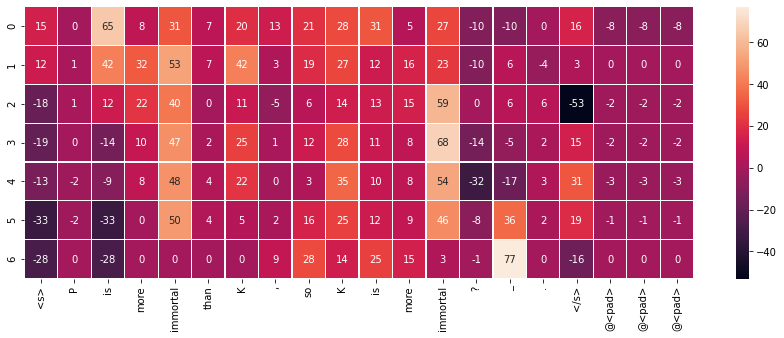

In [165]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(n_layers))
ax = sns.heatmap((np.array(layer_attrs) * 100).astype('int64'), xticklabels=xticklabels, yticklabels=yticklabels, annot=True, fmt='d', linewidth=0.2)
# plt.xlabel('Tokens')
# plt.ylabel('Layers')
plt.show()

In [167]:
remove_interpretable_embedding_layer(model, interpretable_embedding)

In [346]:
_ = model.eval()
inputs = trainer._prepare_inputs(inputs, model)
with torch.no_grad():
    loss, logits, probe_logits, all_attentions = model(**inputs, output_attentions=True, probe_positions=probe_positions)[:4]

attn_scores, attn_probs = zip(*all_attentions)
attn_scores, attn_probs = torch.stack(attn_scores, dim=0), torch.stack(attn_probs, dim=0)
attn_probs = attn_probs.cpu()

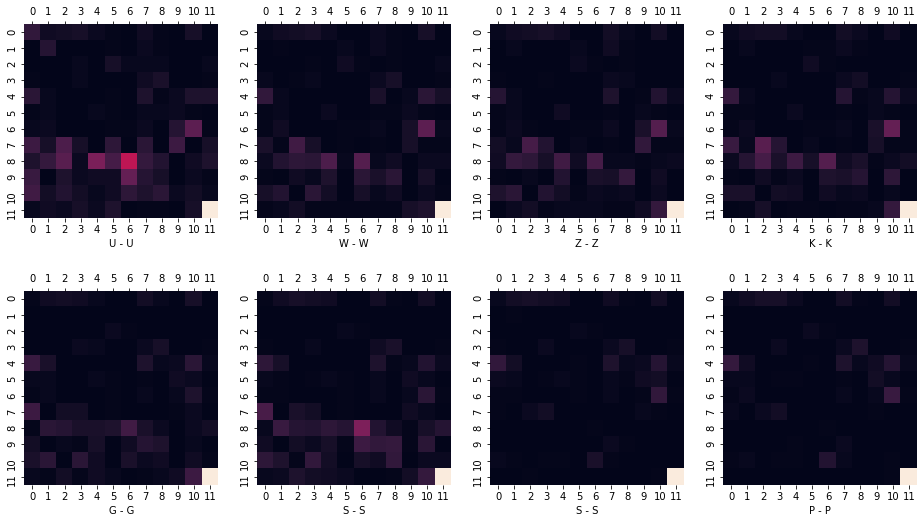

In [322]:
sample_indices = [[0, 1, 2, 3], 
                  [4, 5, 6, 7]]
# sample_indices = [[0, 0], 
#                   [0, 0]]
n_rows, n_cols = len(sample_indices), len(sample_indices[0])
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(4 * n_cols, 4.5 * n_rows))
sep_id = tokenizer._convert_token_to_id('Ġ,')
for row in range(n_rows):
    for col in range(n_cols):
        i, ax = sample_indices[row][col], axs[row][col]
        tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i]))
        
        p, h = inputs['marked_pos_labels'][i][0]
        p, h = p.item(), h.item()
        so_pos = (inputs['input_ids'][i] == tokenizer._convert_token_to_id('Ġso')).nonzero()[0, 0].item()
        be2_pos = so_pos + 2
        mask_pos = (inputs['input_ids'][i] == tokenizer.mask_token_id).nonzero()[0, 0].item()
#         j = 17
        pos_attn = attn_probs[:, i, :, mask_pos, h]
        pos_attn[-1, -1] = 1.
        ax = sns.heatmap((pos_attn * 100).long(), square=True, cbar=False, annot=False, fmt='d', ax=ax)
        ax.tick_params(top=True, labeltop=True)
        _ = ax.set_xlabel('%s - %s' % (tokens[p], tokens[h]))

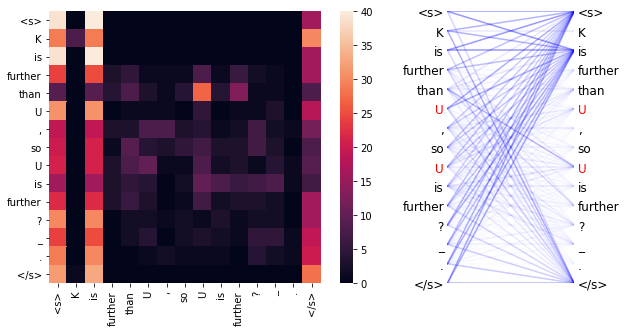

In [368]:
i = 0
layer, head = 5, 9
seq_len = inputs['attention_mask'][i].sum().item()
attn =  attn_probs[layer, i, head, : seq_len, : seq_len]
tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[: seq_len])
size = round(attn.size(0) / 3)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(size  * 2., size), gridspec_kw={'width_ratios': [3, 1]})
_ = sns.heatmap((attn * 100).long(), square=True, cbar=True, annot=False, fmt='d', xticklabels=tokens, yticklabels=tokens, ax=ax0)
plot_head_attn(attn, tokens, ax1=ax1, marked_positions=inputs['marked_pos_labels'][i])

In [ ]:
H6-4: ,/so/is/more -> h_ent
H6-6: ,/so/is/more -> h
H6-10: ,/so/is/more -> p
H7-9: ?/mask -> so

In [ ]:
#         pos_attn = attn_probs[:, i]
#         pos_attn = pos_attn * (pos_attn > 0.3)
# #         pos_attn[0] = 0  # layer 0
# #         pos_attn[1, 1] = 0  # ->pos-2
#         pos_attn = pos_attn.mean(dim=(0, 1))
#         input_ids = inputs['input_ids'][i]
#         sep_pos = (input_ids == sep_id).nonzero()[0].item()
#         segment_ids = torch.zeros_like(input_ids)
#         segment_ids[sep_pos + 1:] = 1
#         segment_mask = segment_ids.unsqueeze(0) != segment_ids.unsqueeze(1)
#         pos_attn = pos_attn * segment_mask.cpu()
#         seq_len = inputs['attention_mask'][i].sum().item()
#         pos_attn[:, [0, 2, seq_len - 1]] = 0
#         k = torch.arange(1, pos_attn.size(0) - 1)
#         pos_attn[k, k] = 0
#         pos_attn[k, k - 1] = 0
#         pos_attn[k, k + 1] = 0
#         ax = sns.heatmap((pos_attn * 100).long(), square=True, cbar=False, annot=False, fmt='d', 
#                          xticklabels=tokens, yticklabels=tokens, ax=ax)